In [6]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt

In [7]:
def motion_constraints(Iref, Inext):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    Iref = Iref / 255. # normalize pixels
    Inext = Inext / 255. # normalize pixels
    mode = 'same'
    Ix = signal.convolve2d(Iref, kernel_x, boundary='symm', mode=mode)
    Iy = signal.convolve2d(Iref, kernel_y, boundary='symm', mode=mode)
    It = signal.convolve2d(Inext, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(Iref, -kernel_t, boundary='symm', mode=mode)
    return Ix, Iy, It

In [21]:
frame0 = cv2.imread('./images/frame0.jpg')
frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
frame1 = cv2.imread('./images/frame15.jpg')
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
# frame1 = cv2.resize(frame1, (87,87))

In [22]:
Ix, Iy, It = motion_constraints(frame0, frame1)

In [23]:
def lucas_kanade(Iref, Inext, window_size=3, tau=1e-1):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    Iref = Iref / 255. # normalize pixels
    Inext = Inext / 255. # normalize pixels
    mode = 'same'
    fx = signal.convolve2d(Iref, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(Iref, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(Inext, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(Iref, -kernel_t, boundary='symm', mode=mode)
    w= window_size//2
    u = np.zeros(Iref.shape)
    v = np.zeros(Iref.shape)
    # within window window_size * window_size
    for i in range(w, Iref.shape[0]-w):
        for j in range(w, Iref.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1)) # get b here
            A = np.vstack((Ix, Iy)).T # get A here

            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]
    plt.imshow(Iref, cmap='gray')
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            if abs(u[i,j])>tau or abs(v[i,j])>tau:
                plt.arrow(j,i,v[i,j],u[i,j],head_width = 2, head_length = 2, color = 'r')

    return (u,v)

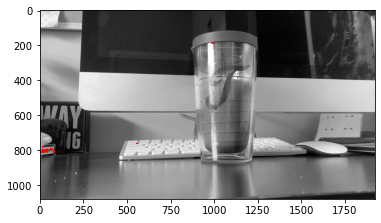

In [24]:
u,v = lucas_kanade(frame0, frame1, window_size=5)

C:\Users\torip\AppData\Local\Temp\ipykernel_6892\666938335.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(np.arctan(u/v), cmap='gray')


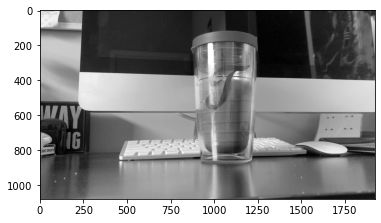

In [16]:
plt.imshow(u, cmap='gray')
plt.imshow(v, cmap='gray')
plt.imshow(u**2+v**2, cmap='gray')
plt.imshow(np.arctan(u/v), cmap='gray')
plt.imshow(frame0, cmap='gray')
plt.imshow(frame1, cmap='gray')